## 라이브러리 호출 및 함수 정의

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timeit

from numpy import random
from scipy.stats import norm, multivariate_normal
from scipy import interpolate
from scipy.stats.mvn import mvnun
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mvbin import mvbin

/var/folders/cc/6xhsqlks6mg1kzb03g_1zn7r0000gn/T/ipykernel_26640/1110515771.py:10: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  from scipy.stats.mvn import mvnun


In [2]:
# make random multivariate normal distributions
def make_mvn(n=50, mean=0, ro=0.9, ro_var=1, snp=10000):
    mean_vec = [mean]*n
    cov_vec = [[ro]*n for _ in range(n)]
    for i in range(n):
        cov_vec[i][i]= ro_var
    X = random.multivariate_normal(mean = mean_vec,
                                   cov  = cov_vec,
                                   size = snp)
    X = pd.DataFrame(X)
    return X

# make random multivariate normal distributions
def make_mvn2(mean_vec, cov_vec, snp=10000):
    X = random.multivariate_normal(mean = mean_vec,
                                   cov  = cov_vec,
                                   size = snp)
    X = pd.DataFrame(X)
    return X

# logistic transformation
def logit_transform(x):
    return np.e**x/(1+np.e**x)

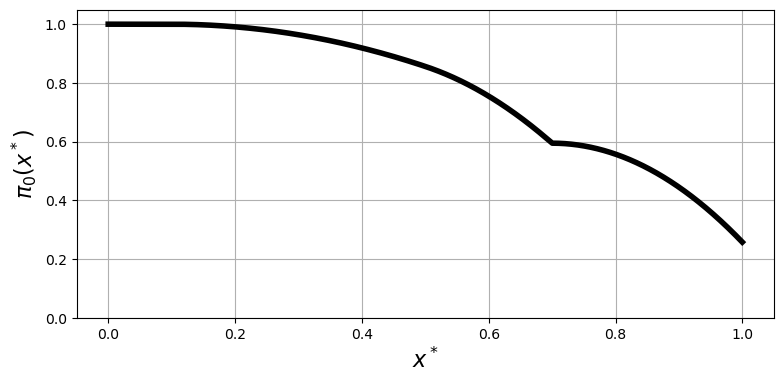

In [3]:
# smooth pi_0 funtions of covatiates
def f1(x):
    p2 = -0.2
    p1 = 1.2
    a = 4 / (p1 - p2)**2
    
    y = -a * (x - p1) * (x - p2)
    y[x >= 0.7] = -a * (0.7 - p1) * (0.7 - p2)
    y[x <= (p1 + p2) / 2] = 1
    return y

def f2(x):
    y = np.zeros_like(x)
    y[x >= 0.7] = -2.5 * (x[x >= 0.7] - 0.7)**2
    return y

def f3(x):
    y = np.zeros_like(x)
    y[x < 0.7] = -(x[x < 0.7] - 0.1)**2
    y[x >= 0.7] = -(0.7 - 0.1)**2
    y[x <= 0.1] = 0
    return y

def f(x1, x2):
    y1 = f1(x1)
    y2 = f2(x1)
    y3 = f3(x1)
    
    y = np.zeros_like(x1)
    y[x2 == 1] = y1[x2 == 1] + y2[x2 == 1] + 0.12 * y3[x2 == 1]
    y[x2 == 2] = y1[x2 == 2] + 0.5 * y2[x2 == 2] + 0.06 * y3[x2 == 2]
    y[x2 == 3] = y1[x2 == 3] + 0.3 * y2[x2 == 3]
    return y

def fSingle(x):
    y1 = f1(x)
    y2 = f2(x)
    y3 = f3(x)
    
    y = y1 + 1.5 * y2 + 0.9 * y3
    return y

plt.figure(figsize=(9,4))
x = np.arange(0, 1, 0.0001)
pi0 = fSingle(x)
plt.plot(x, pi0, color='black', linewidth=4)
plt.ylim(0, 1.05)
plt.xlabel('$x^*$', size=16)
plt.ylabel('$\pi_0(x^*)$', size=16)
plt.grid()
plt.savefig("../../Figure/simul_BL_pca/Distribution of pi0.pdf")
#plt.show()

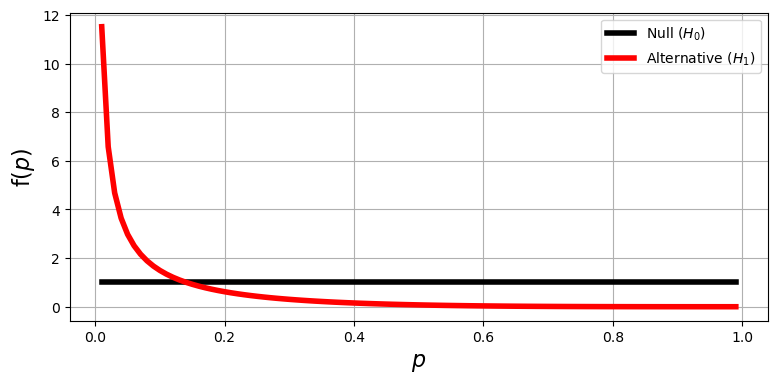

In [4]:
from numpy import linspace
from scipy.stats import beta

a = np.random.uniform(0.2,0.4)
b = 4
x = linspace(.01, .99, 99)
y1 = np.ones(99)
y2 = beta(a, b).pdf(x)      


plt.figure(figsize=(9,4))
plt.plot(x, y1, 'black', linewidth=4, label = 'Null ($H_0$)')  
plt.plot(x, y2, 'red', linewidth=4, label = 'Alternative ($H_1$)')        
plt.xlabel('$p$', size=16)
plt.ylabel('f($p$)', size=16)
plt.grid()
plt.legend()
plt.savefig("../../Figure/simul_BL_pca/Distribution of pval.pdf")

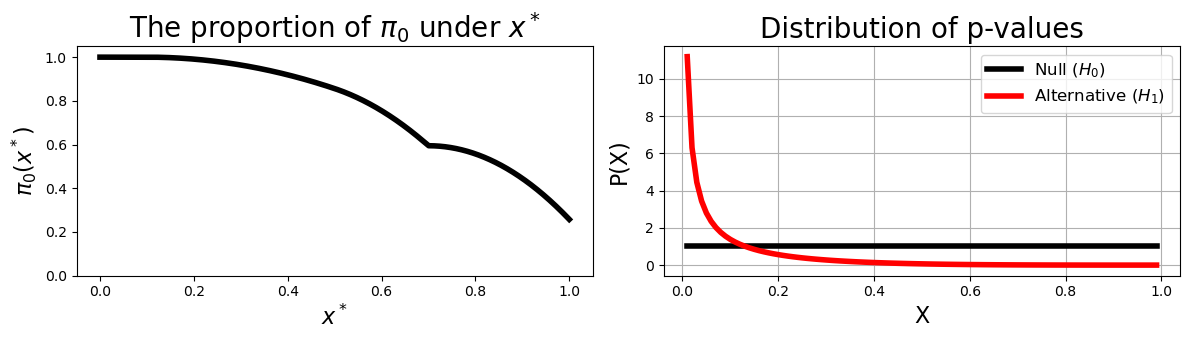

In [6]:
plt.figure(figsize=(12,3.5))

plt.subplot(1,2,1)
x = np.arange(0, 1, 0.0001)
pi0 = fSingle(x)
plt.plot(x, pi0, color='black', linewidth=4)
plt.ylim(0, 1.05)
plt.xlabel('$x^*$', size=16)
plt.ylabel('$\pi_0(x^*)$', size=16)
plt.title('The proportion of $\pi_0$ under $x^*$', size = 20) 

a = np.random.uniform(0.2,0.4)
b = 4
x = linspace(.01, .99, 99)
y1 = np.ones(99)
y2 = beta(a, b).pdf(x)      

plt.subplot(1,2,2)
plt.plot(x, y1, 'black', linewidth=4, label = 'Null ($H_0$)')  
plt.plot(x, y2, 'red', linewidth=4, label = 'Alternative ($H_1$)')        
plt.xlabel('X', size=16)
plt.ylabel('P(X)', size=16)
plt.grid()
plt.legend(fontsize=12)
plt.title('Distribution of p-values', size = 20) 

plt.tight_layout()
#plt.show()
plt.savefig("../../Figure/simul_BL_pca/Distribution of pi0_pval.pdf")

## simulation matrix 생성

In [7]:
mean_vec = [0]*30
A = random.randint(2, size = (30,30))
cov_vec = A@A.transpose()

sigma = np.diag(np.ones(30))
for i in range(len(sigma)):
    for j in range(i + 1, len(sigma)):
        sigma[i, j] = sigma[j, i] = (0.2)**(abs(i-j))

In [8]:
# true eigenvalue
sample = mvbin(p=[0.1]*30, rho=sigma, size=10000000)
X = pd.DataFrame(sample.astype('int')) * abs(make_mvn2(mean_vec, cov_vec, snp=10000000))

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns = ['PC'+str(i) for i in range(1,31)])

true_eigenvalue = pd.DataFrame(pca.components_).transpose()
true_eigenvalue

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.178641,-0.074617,0.003124,-0.150015,-0.127061,0.175094,-0.222985,0.171715,0.190778,0.287139,...,-0.198608,-0.025430,-0.014261,-0.279745,-0.221206,-0.092914,-0.092690,-0.015431,-0.020097,0.004905
1,0.163634,-0.129396,0.005919,-0.242913,-0.169459,0.261874,-0.282448,0.180677,0.195976,0.271801,...,0.308120,0.020220,0.051380,0.410122,0.309015,0.182104,0.152312,-0.037465,0.021993,-0.034517
2,0.158880,-0.147210,-0.021606,-0.315639,-0.137988,0.249070,-0.213872,0.132954,-0.007216,0.007793,...,-0.214429,0.060607,-0.090894,-0.270937,-0.247435,-0.221267,-0.199029,0.139790,-0.057630,0.026393
3,0.172464,-0.200977,-0.028590,-0.338384,-0.091875,0.160985,-0.009045,0.003720,-0.187305,-0.279944,...,-0.004152,-0.122483,0.119155,0.056033,0.129371,0.258230,0.227509,-0.272581,0.119502,-0.002945
4,0.200248,-0.242702,-0.051938,-0.300923,-0.016394,0.014615,0.171933,-0.135667,-0.242050,-0.263264,...,0.160309,0.135630,-0.073224,0.128266,0.059371,-0.223018,-0.210302,0.368111,-0.217369,-0.034798
5,0.182214,-0.287741,-0.057723,-0.217884,0.057990,-0.126251,0.295790,-0.204446,-0.144849,0.002219,...,-0.101547,-0.039161,0.002555,-0.151157,-0.228473,0.063678,0.162319,-0.373861,0.280120,0.008310
6,0.165677,-0.278674,-0.040379,-0.098509,0.128556,-0.246186,0.287923,-0.100023,0.047298,0.247086,...,-0.134200,-0.085630,0.079784,0.074617,0.275039,0.088574,-0.104590,0.290439,-0.296758,0.002691
7,0.150234,-0.236817,-0.060850,0.002946,0.180502,-0.283078,0.146626,0.066359,0.231249,0.275446,...,0.305833,0.178497,-0.162503,0.022357,-0.181141,-0.202575,0.040915,-0.169346,0.228236,-0.013465
8,0.142726,-0.210111,-0.076749,0.114619,0.220921,-0.216238,-0.033130,0.246508,0.246319,0.058430,...,-0.295814,-0.149085,0.194607,-0.098801,0.009068,0.314673,0.084468,0.089992,-0.179476,0.000781
9,0.171920,-0.206964,-0.109800,0.226710,0.205803,-0.103968,-0.200617,0.273203,0.097628,-0.193847,...,0.109304,-0.012156,-0.082941,0.185805,0.133405,-0.387090,-0.195426,-0.079420,0.211694,0.014139


In [ ]:
def make_covariate_matrix(sigma):
    # X_matrix
    sample = mvbin(p=[0.1]*30, rho=sigma, size=20000)
    X = pd.DataFrame(sample.astype('int')) * abs(make_mvn2(mean_vec, cov_vec, snp=20000))
    
    # X_pca_matrix
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X))
    
    pca = PCA()
    X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns = ['PC'+str(i) for i in range(1,31)])
    
    pi1 = 1 - fSingle(logit_transform(X_scaled@true_eigenvalue.iloc[:,2]))
    
    # generate sample dataframe
    p, h, X = generate_data_1D_cont(pi1, X)
    df = pd.concat([pd.Series(p), pd.Series(h), pd.DataFrame(X), pd.DataFrame(X_pca)], axis=1)
    df.columns = ['p', 'h'] + list(range(30)) + ['PC'+str(i) for i in range(1,31)]
    df = df.astype({'h':'int'})
    return df

for i in range(1, 101):
    df = make_covariate_matrix(sigma)
    df.to_csv("../../Data/data_simul/df_MVB_%d.csv"%i, index=None)

## BH & Storey

In [21]:
from statsmodels.stats.multitest import multipletests

def Bonferroni(x):
    ic = multipletests(df.p, method='bonferroni')[0].sum()
    pval = multipletests(df.p, method='bonferroni')[3]

    return ic, pval

def BH(x, alpha = 0.05, n = None):
    x_s = sorted(x)
    if n is None:
        n = len(x_s)
    ic = 0
    for i in range(len(x_s)):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic]

def Storey_BH(x, alpha = 0.05, lamb=0.4, n = None):
    pi0_hat=np.divide(np.sum(x>lamb),x.shape[0] *(1-lamb))
    alpha /= pi0_hat
    x_s = sorted(x)
    if n is None:
        n = len(x_s)
    ic = 0
    for i in range(len(x_s)):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic], pi0_hat

info = pd.DataFrame(np.zeros((100,10)))
info.columns = ['disc_true','disc_FWER','disc_BH','disc_Storey','TPR_FWER','TPR_BH','TPR_Storey','FDR_FWER','FDR_BH','FDR_Storey']
for r in range(100):
    #print('Simul :', r+1)
    # generate sample
    df = pd.read_csv("../../Data/data_simul/df_MVB_%d.csv"%(r+1))
    info.loc[r,'disc_true'] = sum(df.h)
    
    # FWER
    reject_FWER, pval_FWER = Bonferroni(df.p)
    result_FWER = df[df.p <= pval_FWER]
    
    info.loc[r,'disc_FWER'] = reject_FWER
    info.loc[r,'TPR_FWER'] = len(result_FWER[result_FWER.h == 1])/sum(df.h)
    info.loc[r,'FDR_FWER'] =len(result_FWER[result_FWER.h == 0])/len(result_FWER)
    
    # BH
    reject_BH, pval_BH = BH(df.p, alpha=0.05)
    result_BH = df[df.p <= pval_BH]
    
    info.loc[r,'disc_BH'] = reject_BH
    info.loc[r,'TPR_BH'] = len(result_BH[result_BH.h == 1])/sum(df.h)
    info.loc[r,'FDR_BH'] =len(result_BH[result_BH.h == 0])/len(result_BH)

    # Storey
    reject_Storey, pval_Storey, pi0_hat = Storey_BH(df.p, alpha=0.05)
    result_Storey = df[df.p <= pval_Storey]
    
    info.loc[r,'disc_Storey'] = reject_Storey
    info.loc[r,'TPR_Storey'] = len(result_Storey[result_Storey.h == 1])/sum(df.h)
    info.loc[r,'FDR_Storey'] = len(result_Storey[result_Storey.h == 0])/len(result_Storey)
    
info.to_csv("../../Data/result_final/simul_BL_pca/info_MVB_simul100_Basic.csv", index=None)
info

,disc_true,disc_FWER,disc_BH,disc_Storey,TPR_FWER,TPR_BH,TPR_Storey,FDR_FWER,FDR_BH,FDR_Storey
0,3829.0,147.0,1108.0,1204.0,0.038391,0.275790,0.297728,0.0,0.047791,0.053942
1,3833.0,137.0,1190.0,1307.0,0.035742,0.295069,0.320897,0.0,0.050378,0.059633
2,3852.0,179.0,1227.0,1332.0,0.046469,0.303998,0.327622,0.0,0.046417,0.053263
3,3854.0,166.0,1217.0,1334.0,0.043072,0.303062,0.328749,0.0,0.041051,0.050936
4,3877.0,168.0,1267.0,1385.0,0.043332,0.311581,0.338406,0.0,0.047319,0.053391
...,...,...,...,...,...,...,...,...,...,...
95,3789.0,165.0,1191.0,1299.0,0.043547,0.301927,0.326471,0.0,0.040268,0.048462
96,3782.0,173.0,1204.0,1322.0,0.045743,0.304072,0.330513,0.0,0.045643,0.055178
97,3829.0,173.0,1144.0,1272.0,0.045182,0.288326,0.318360,0.0,0.035808,0.042419
98,3915.0,166.0,1242.0,1364.0,0.042401,0.303959,0.332312,0.0,0.042639,0.046886


In [23]:
info = pd.read_csv("../../Data/result_final/simul_BL_pca/info_MVB_simul100_Basic.csv")
pd.DataFrame(info.mean(axis=0))

,0
disc_true,3819.840000
disc_FWER,162.220000
disc_BH,1168.820000
disc_Storey,1279.720000
TPR_FWER,0.042456
TPR_BH,0.293565
TPR_Storey,0.318432
FDR_FWER,0.000240
FDR_BH,0.041292
FDR_Storey,0.050083


## simul BL result with PC transformed cov

In [24]:
dfs = pd.DataFrame(pd.read_csv("../../Data/result_final/simul_BL_pca/info_MVB_simul100.csv"))
dfs = pd.DataFrame(dfs.mean(axis=0))


disc_IHW = dfs.iloc[dfs[0].index.str.contains('disc_IHW'),]
disc_BL = dfs.iloc[dfs[0].index.str.contains('disc_BL'),]

FDR_IHW = dfs.iloc[dfs[0].index.str.contains('FDR_IHW'),]
FDR_BL = dfs.iloc[dfs[0].index.str.contains('FDR_BL'),]

TPR_IHW = dfs.iloc[dfs[0].index.str.contains('TPR_IHW'),]
TPR_BL = dfs.iloc[dfs[0].index.str.contains('TPR_BL'),]


column_list = list(range(1,31))
disc_IHW.index = column_list
disc_BL.index = column_list
FDR_IHW.index = column_list
FDR_BL.index = column_list
TPR_IHW.index = column_list
TPR_BL.index = column_list

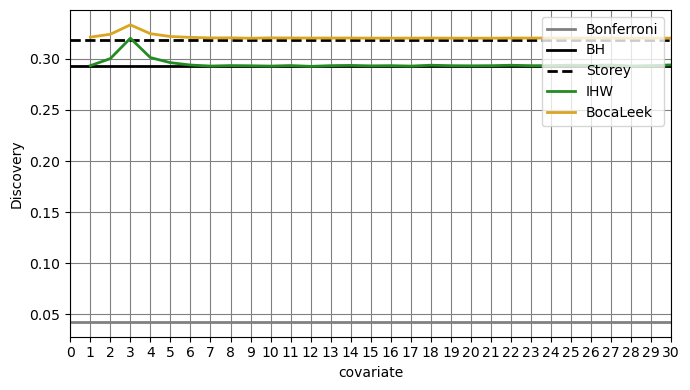

In [26]:
plt.figure(figsize=(7,4))
plt.axhline(y=info.mean(axis=0)["TPR_FWER"], color="grey", linewidth=2, label = 'Bonferroni')
plt.axhline(y=info.mean(axis=0)["TPR_BH"], color="black", linewidth=2, label = 'BH')
plt.axhline(y=info.mean(axis=0)["TPR_Storey"], color="black", linewidth=2, linestyle="--",  label = 'Storey')
plt.plot(TPR_IHW, color="forestgreen", linewidth=2, label = 'IHW')
plt.plot(TPR_BL, color="goldenrod", linewidth=2, label = 'BocaLeek')

plt.legend(loc='upper right')
plt.xlabel("covariate")
plt.ylabel("Discovery")
plt.grid(color="grey")
plt.xlim(1,30)
plt.xticks(np.arange(0, 31, step=1))
#plt.yticks(range(0, 375, 50))
plt.tight_layout()

plt.show()

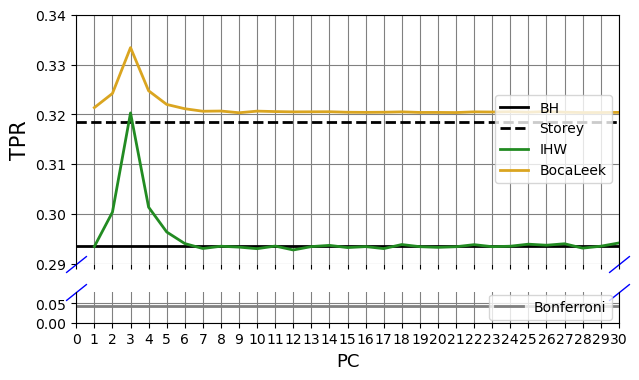

In [40]:
from matplotlib.gridspec import GridSpec
from string import ascii_lowercase, ascii_uppercase

fig = plt.figure(figsize=(7,4))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[8, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

d = .8    # how big to make the diagonal lines in axes coordinates

kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15, linestyle="none", color='blue', clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlim(1,30)
ax2.set_ylim(0, 0.08)

ax2.set_xlabel("PC", size=13)

ax2.grid(color="grey")
ax2.set_xticks(np.arange(0, 31, step=1))

ax2.axhline(y=info.mean(axis=0)["TPR_FWER"], color="grey", linewidth=2, label = 'Bonferroni')
ax1.axhline(y=info.mean(axis=0)["TPR_BH"], color="black", linewidth=2, label = 'BH')
ax1.axhline(y=info.mean(axis=0)["TPR_Storey"], color="black", linewidth=2, linestyle="--",  label = 'Storey')
ax1.plot(TPR_IHW, color="forestgreen", linewidth=2, label = 'IHW')
ax1.plot(TPR_BL, color="goldenrod", linewidth=2, label = 'BocaLeek')

#ax1.set_title("effsize=3", fontsize=15)
ax1.legend(loc="right")
ax2.legend(loc="right")
ax1.set_xlim(1,30)
ax1.set_ylim(0.29, 0.34)

ax1.set_ylabel("TPR", size=15)
ax1.grid(color="grey")
ax1.set_xticks(np.arange(0, 31, step=1))
ax1.set_xticklabels([])

plt.savefig("../../Figure/simul_BL_pca/result_simul_BL_pca_TPR.pdf")
#plt.show()

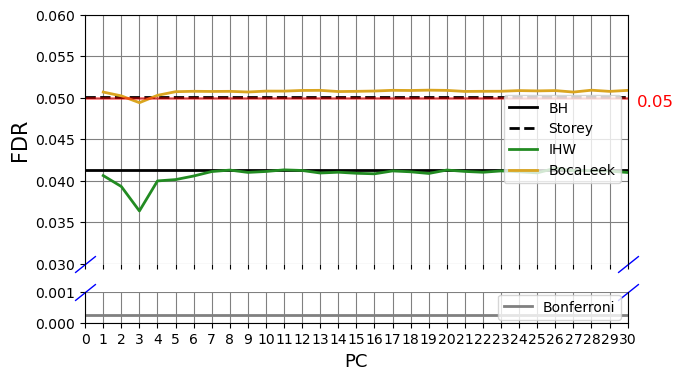

In [43]:
from matplotlib.gridspec import GridSpec
from string import ascii_lowercase, ascii_uppercase

fig = plt.figure(figsize=(7,4))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[8, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

d = .8    # how big to make the diagonal lines in axes coordinates

kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15, linestyle="none", color='blue', clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlim(1,30)
ax2.set_ylim(0, 0.001)

ax2.set_xlabel("PC", size=13)

ax2.grid(color="grey")
ax2.set_xticks(np.arange(0, 31, step=1))

ax2.axhline(y=info.mean(axis=0)["FDR_FWER"], color="grey", linewidth=2, label = 'Bonferroni')
ax1.axhline(y=info.mean(axis=0)["FDR_BH"], color="black", linewidth=2, label = 'BH')
ax1.axhline(y=info.mean(axis=0)["FDR_Storey"], color="black", linewidth=2, linestyle="--",  label = 'Storey')
ax1.plot(FDR_IHW, color="forestgreen", linewidth=2, label = 'IHW')
ax1.plot(FDR_BL, color="goldenrod", linewidth=2, label = 'BocaLeek')

ax1.axhline(y=0.05, color="red", linewidth=2, alpha=0.5)
ax1.text(30.5, 0.049, "0.05", color = 'red', size = 12)

ax1.legend(loc="right")
ax2.legend(loc="right")
ax1.set_xlim(1,30)
ax1.set_ylim(0.03, 0.06)

ax1.set_ylabel("FDR", size=15)
ax1.grid(color="grey")
ax1.set_xticks(np.arange(0, 31, step=1))
ax1.set_xticklabels([])

plt.savefig("../../Figure/simul_BL_pca/result_simul_BL_pca_FDR.pdf")
#plt.show()